In [135]:
from pyneurovault import api
import pandas as pd
from nilearn.image import resample_img, smooth_img
from nilearn.plotting import plot_glass_brain, plot_roi
import seaborn as sns
%matplotlib inline
import nibabel as nb
import numpy as np
from scipy.ndimage import binary_fill_holes
from scipy import stats
from scipy.ndimage.measurements import labeled_comprehension
import pylab as plt

In [146]:
map_ids = [14248]#[14250, 14251, 14252, 14257, 14263, 14265, 14267, 1417, 14247, 14246]

atlases = api.get_images(pks=map_ids)
api.download_images("atlases", atlases, resample=False)

Extracting NeuroVault images meta data...
Retrieving image 14248...


,add_date,analysis_level,brain_coverage,cognitive_contrast_cogatlas,cognitive_contrast_cogatlas_id,cognitive_paradigm_cogatlas,cognitive_paradigm_cogatlas_id,collection,collection_id,contrast_definition,...,modify_date,name,not_mni,perc_bad_voxels,perc_voxels_outside,reduced_representation,smoothness_fwhm,statistic_parameters,thumbnail,url
0,2016-01-03T04:23:07.538238Z,None,57.3132,rest eyes open,cnt_54e6a3ceb7216,rest eyes open,trm_4c8a834779883,http://neurovault.org/collections/1057/,1057,,...,2016-01-03T04:25:42.137972Z,17 Networks LiberalMask,False,93.7133,0.733031,None,None,None,http://neurovault.org/media/images/1057/glass_...,http://neurovault.org/images/14248/


In [147]:
filenames = !ls atlases/original/*.nii.gz
standard = "/usr/local/fsl/data/standard/MNI152_T1_2mm_brain.nii.gz"

!mkdir -p atlases/resampled

for fname in filenames:
    fname = fname.split("/")[-1]
    print "resampling " + fname
    nii = nb.load("atlases/original/" + fname)

    target_nii = nb.load(standard)
    resampled_nii = resample_img(nii,target_affine=target_nii.get_affine(), 
                                 target_shape=target_nii.shape, interpolation='nearest')
    resampled_nii.to_filename("atlases/resampled/" + fname)

resampling 1417.nii.gz
resampling 14246.nii.gz
resampling 14247.nii.gz
resampling 14248.nii.gz
resampling 14250.nii.gz
resampling 14251.nii.gz
resampling 14252.nii.gz
resampling 14257.nii.gz
resampling 14263.nii.gz
resampling 14265.nii.gz
resampling 14267.nii.gz


In [148]:
def score_map(map_filename, atlas_data, labels):
    map_data = nb.load(map_filename).get_data()
    parcel_means = labeled_comprehension(map_data,
                                             atlas_data,
                                             list(labels),
                                             np.mean,
                                             float,
                                             np.nan)
    parcel_variance = labeled_comprehension(map_data,
                                             atlas_data,
                                             list(labels),
                                             np.var,
                                             float,
                                             np.nan)
    within_variance = parcel_variance.mean()
    between_variance = parcel_means.var()
    return within_variance, between_variance

In [149]:
comparisons_df = pd.DataFrame(columns=["within_parcel_variance", "between_parcel_variance", "atlas_id", "image_id", "fake_map_id"])

In [150]:
df = pd.read_csv("smoothness_and_volume.csv", index_col=0)

for i, atlas_row in atlases.iterrows():
    atlas_id = atlas_row["image_id"]
    print "analyzing " + atlas_row["name"]
    atlas_nii = nb.load("atlases/resampled/%04d.nii.gz"%atlas_id)
    
    for image_id, row in df.iterrows():
        fname = "%04d.nii.gz"%image_id
        print "analyzing " + fname
        mask_nii = nb.load("images/resampled_masks/%04d.nii.gz"%image_id)
        atlas_data = atlas_nii.get_data().copy()
        atlas_data[mask_nii.get_data() != True] = 0
        labels = set(np.unique(atlas_data)) - set([0])
        
        if not ((comparisons_df['atlas_id'] == atlas_id) & (comparisons_df['image_id'] == image_id)).any():
            real_within_variance, real_between_variance = score_map("images/resampled/%04d.nii.gz"%image_id, atlas_data, labels)
            comparisons_df = comparisons_df.append({"within_parcel_variance": real_within_variance, 
                                   "between_parcel_variance": real_between_variance, 
                                   "atlas_id": atlas_id, 
                                   "image_id": image_id,
                                   "fake_map_id": None}, ignore_index=True)
        
        from joblib import Parallel, delayed
        out = Parallel(n_jobs=2)(delayed(score_map)("images/fake_maps/%04d/%04d.nii.gz"%(image_id, fake_map_id), 
                                                                                   atlas_data, 
                                                                                   labels) for fake_map_id in range(200))
        comparisons_df = comparisons_df.append(pd.DataFrame({"within_parcel_variance": list(np.array(out)[:, 0]), 
                                       "between_parcel_variance": list(np.array(out)[:, 1]), 
                                       "atlas_id": [atlas_id]*200, 
                                       "image_id": [image_id]*200,
                                       'fake_map_id':range(200)}), ignore_index=True)

analyzing 17 Networks LiberalMask
analyzing 0112.nii.gz
analyzing 0113.nii.gz
analyzing 0111.nii.gz
analyzing 0110.nii.gz
analyzing 2737.nii.gz
analyzing 2735.nii.gz
analyzing 2738.nii.gz
analyzing 2734.nii.gz
analyzing 2739.nii.gz
analyzing 2743.nii.gz
analyzing 2744.nii.gz
analyzing 11979.nii.gz
analyzing 11981.nii.gz
analyzing 11980.nii.gz
analyzing 10925.nii.gz
analyzing 8625.nii.gz
analyzing 8626.nii.gz
analyzing 12488.nii.gz
analyzing 12485.nii.gz
analyzing 12491.nii.gz
analyzing 12487.nii.gz
analyzing 12490.nii.gz
analyzing 12496.nii.gz
analyzing 12492.nii.gz
analyzing 12493.nii.gz
analyzing 12494.nii.gz
analyzing 12495.nii.gz
analyzing 12486.nii.gz
analyzing 12489.nii.gz
analyzing 0141.nii.gz
analyzing 0135.nii.gz
analyzing 0138.nii.gz
analyzing 0140.nii.gz
analyzing 0136.nii.gz
analyzing 0139.nii.gz
analyzing 0180.nii.gz
analyzing 0175.nii.gz
analyzing 0183.nii.gz
analyzing 0177.nii.gz
analyzing 0181.nii.gz
analyzing 0178.nii.gz
analyzing 0300.nii.gz
analyzing 0307.nii.gz
anal

In [152]:
comparisons_df.to_csv("yeo_17_comparisons.csv")

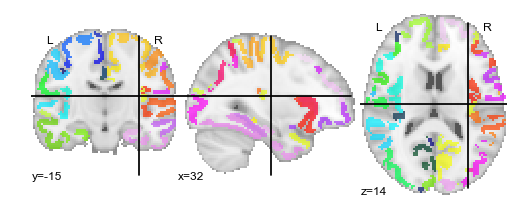

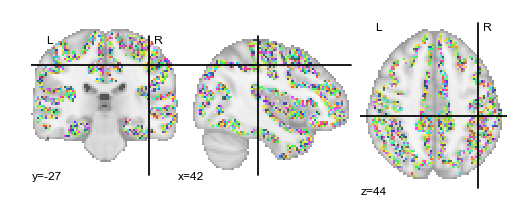

In [138]:
nii = nb.load("atlases/resampled/14251.nii.gz")
mask = nii.get_data() != 0
new_data = nii.get_data().copy()
new_data[mask] = np.random.permutation(nii.get_data()[mask])
new_nii = nb.Nifti1Image(new_data, nii.affine, nii.header)
plot_roi(nii)
plot_roi(new_nii)
new_nii.to_filename("atlases/resampled/fake_gordon.nii.gz")

In [141]:
df = pd.read_csv("smoothness_and_volume.csv", index_col=0)
fake_comparisons_df = pd.DataFrame(columns=["within_parcel_variance", "between_parcel_variance", "atlas_id", "image_id", "fake_map_id"])

atlas_id = "fake_gordon"
print "analyzing " + atlas_row["name"]
atlas_nii = nb.load("atlases/resampled/fake_gordon.nii.gz")

for image_id, row in df.iterrows():
    fname = "%04d.nii.gz"%image_id
    print "analyzing " + fname
    mask_nii = nb.load("images/resampled_masks/%04d.nii.gz"%image_id)
    atlas_data = atlas_nii.get_data().copy()
    atlas_data[mask_nii.get_data() != True] = 0
    labels = set(np.unique(atlas_data)) - set([0])

    if not ((fake_comparisons_df['atlas_id'] == atlas_id) & (fake_comparisons_df['image_id'] == image_id)).any():
        real_within_variance, real_between_variance = score_map("images/resampled/%04d.nii.gz"%image_id, atlas_data, labels)
        fake_comparisons_df = fake_comparisons_df.append({"within_parcel_variance": real_within_variance, 
                               "between_parcel_variance": real_between_variance, 
                               "atlas_id": atlas_id, 
                               "image_id": image_id,
                               "fake_map_id": None}, ignore_index=True)

    from joblib import Parallel, delayed
    out = Parallel(n_jobs=4)(delayed(score_map)("images/fake_maps/%04d/%04d.nii.gz"%(image_id, fake_map_id), 
                                                                               atlas_data, 
                                                                               labels) for fake_map_id in range(200))
    fake_comparisons_df = fake_comparisons_df.append(pd.DataFrame({"within_parcel_variance": list(np.array(out)[:, 0]), 
                                   "between_parcel_variance": list(np.array(out)[:, 1]), 
                                   "atlas_id": [atlas_id]*200, 
                                   "image_id": [image_id]*200,
                                   'fake_map_id':range(200)}), ignore_index=True)

analyzing 7 Networks LiberalMask
analyzing 0112.nii.gz
analyzing 0113.nii.gz
analyzing 0111.nii.gz
analyzing 0110.nii.gz
analyzing 2737.nii.gz
analyzing 2735.nii.gz
analyzing 2738.nii.gz
analyzing 2734.nii.gz
analyzing 2739.nii.gz
analyzing 2743.nii.gz
analyzing 2744.nii.gz
analyzing 11979.nii.gz
analyzing 11981.nii.gz
analyzing 11980.nii.gz
analyzing 10925.nii.gz
analyzing 8625.nii.gz
analyzing 8626.nii.gz
analyzing 12488.nii.gz
analyzing 12485.nii.gz
analyzing 12491.nii.gz
analyzing 12487.nii.gz
analyzing 12490.nii.gz
analyzing 12496.nii.gz
analyzing 12492.nii.gz
analyzing 12493.nii.gz
analyzing 12494.nii.gz
analyzing 12495.nii.gz
analyzing 12486.nii.gz
analyzing 12489.nii.gz
analyzing 0141.nii.gz
analyzing 0135.nii.gz
analyzing 0138.nii.gz
analyzing 0140.nii.gz
analyzing 0136.nii.gz
analyzing 0139.nii.gz
analyzing 0180.nii.gz
analyzing 0175.nii.gz
analyzing 0183.nii.gz
analyzing 0177.nii.gz
analyzing 0181.nii.gz
analyzing 0178.nii.gz
analyzing 0300.nii.gz
analyzing 0307.nii.gz
analy

In [144]:
fake_comparisons_df.to_csv("random_parcellation.csv")

In [82]:
score_map("images/fake_maps/%04d/%04d.nii.gz"%(112, 0), 
                                                                        atlas_data, 
                                                                        labels)

(nan, nan)

In [77]:
score_map("images/fake_maps/%04d/%04d.nii.gz"%(image_id, 1), 
                                                                        atlas_data, 
                                                                        labels)

(0.70404898931218218, 0.28268798892388636)

In [78]:
"images/fake_maps/%04d/%04d.nii.gz"%(image_id, 1)

'images/fake_maps/0111/0001.nii.gz'

In [66]:
comparisons_df

,within_parcel_variance,between_parcel_variance,atlas_id,image_id,fake_map,fake_map_id
0,0.514590,0.474610,14250,112,False,NaN
1,0.722390,0.297460,14250,112,True,0
2,0.721904,0.296429,14250,112,True,1
3,0.723791,0.278035,14250,112,True,2
4,0.727070,0.345793,14250,112,True,3
5,0.710931,0.278409,14250,112,True,4
6,0.710555,0.300825,14250,112,True,5
7,0.708334,0.249014,14250,112,True,6
8,0.747286,0.228749,14250,112,True,7
9,0.707251,0.309734,14250,112,True,8


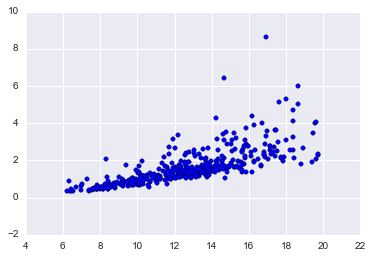

In [6]:
plt.scatter(df.FWHMx_mm, np.array(real_between_variances)/np.array(real_within_variances))

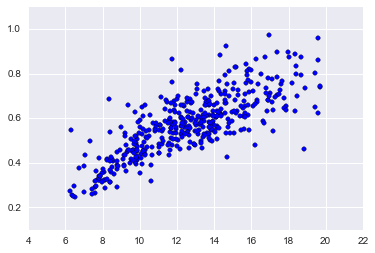

In [7]:
plt.scatter(df.FWHMx_mm, np.array(real_between_variances))

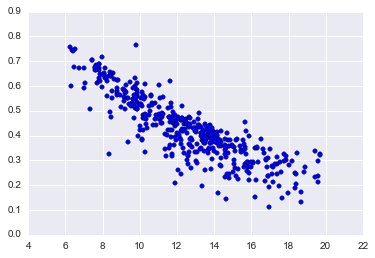

In [8]:
plt.scatter(df.FWHMx_mm, np.array(real_within_variances))

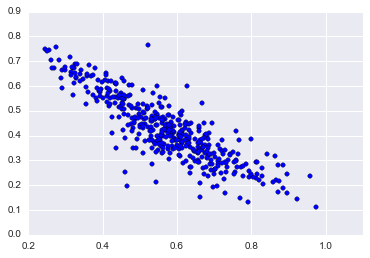

In [9]:
plt.scatter(np.array(real_between_variances), np.array(real_within_variances))

In [10]:
df[np.array(real_within_variances) > 0.9]

,FWHMx_mm,FWHMy_mm,FWHMz_mm,volume_vox


In [11]:
sns.distplot(fake_within_variances)
plt.vlines(real_within_variance,0 ,12)

NameError: name 'fake_within_variances' is not defined

In [ ]:
sns.distplot(np.array(real_between_variances)/np.array(real_within_variances))
#plt.vlines(real_between_variance/real_within_variance, 0 ,12)

In [ ]:
gordon111 = np.array(real_between_variances)/np.array(real_within_variances)

In [ ]:
gordon333 = np.array(real_between_variances)/np.array(real_within_variances)

In [ ]:
sns.distplot(gordon111)
sns.distplot(gordon333)